# Supervised Learning Techniques for Sentiment Analytics
### Data Science Program - Final Capstone Project
### By - Vamshidhar Pandrapagada

In this project, we'll perform sentiment analysis over IMDB movie reviews and Twitter data using Supervised learning
techniques. The goal is to classify these labeled data sets as either positive or negative on training data set and evaluate accuracy of the model on unseen Testing data.

For classification, major part of this project is the task of generating feature vectors using 2 techniques below:

1. Generate Fixed length Feature vectors with traditional Natural Language Processing Techniques (Like Bag of Words Model).
2. Generate Feature vectors using Unsupervised Learning Algorithm called Doc2Vec. 

The feature vectors generated using the above two techniques will be used for classification using Naive Bayes and Logistic-Regression  from python’s well-regarded machine learning package scikit-learn and 4 Layer Feed forward Neural Network using Tensorflow.

### More on the Data Sets

The IMDB reviews and Tweets can be found in the data folder. These have already been divided into train and test sets.

- The [IMDB dataset](http://ai.stanford.edu/~amaas/data/sentiment/) that contains 50,000 reviews split evenly into 25k train and 25k test sets. Overall, there are 25k positive and 25k negative reviews.
    1. Postive review means that a movie was rated with a score of minimum 7 out of 10.
    2. Negative review has a score of less than or equal to 4 out of 10.
    3. Reviews with neutral rating are not included in the Train/Test sets.  
  
  
- The [Twitter Dataset](http://thinknook.com/twitter-sentiment-analysis-training-corpus-dataset-2012-09-22/) contains 900,000 classified tweets split into 750k train and 150k test sets. The overall distribution of labels is balanced (450k pos and 450k neg).

### Project Setup
The python packages we'll need for this project are scikit-learn , nltk , tensorflow and gensim . To install these, simply use the pip installer - **sudo pip install X** or, if using Anaconda - **conda install X**. X is the package name.

In [17]:
import sklearn.naive_bayes as NB
import sklearn.linear_model as LR
import nltk
import random
import numpy as np
import pandas as pd
import pyprind
random.seed(0)
import os
from gensim.models.doc2vec import LabeledSentence, Doc2Vec
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import train_test_split
import tensorflow as tf
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfTransformer
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
import itertools
import matplotlib.pyplot as plt
import multiprocessing

### Read Data from Directory

The following function takes path to the directory as input and reads the data into Python memory.  

- The path to the directory should contain the input data type to be read (Ex IMDB or Twitter). This data type will point to the appropriate directory when open command is invoked.

#### Clean Text (only if the model type is NLP)
- The first important step before creating the bag of words model is to clean the text data by stripping of all the unwanted characters (such as HTML markups, web urls, stop words, spaces etc.) which dont add any value to the sentiment of the text.
- Emoticons created using special characters may have a role to play in sentiment analysis. We'll save these emoticons and strip of other unnecessary special characters.
- Finally split the test corpora into individual words and return the word vectors.

**Text Pre-Processing is not recommended for Doc2Vec Models**  --> Only remove URLS from text. Nothing else.

In [3]:
def load_data(input_type, model_type):
    """
    Loads the train and test set into four different lists.
    """
    train_pos = []
    train_neg = []
    test_pos = []
    test_neg = []
    path_to_dir = os.getcwd()+"\\data\\" + input_type + "\\"
    if (input_type == 'imdb'):
        prog_bar_train = 12500
        prog_bar_test = 12500
    if (input_type == 'twitter'):
        prog_bar_train = 375000
        prog_bar_test = 75000
        
    def text_cleasing(line, model_type):
        if (model_type == 'nlp'):
            emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', line.strip())
            line = re.sub('[\W]+',' ',line.lower()) + ' '.join(emoticons).replace('-','')
        
        #Remove URLs for both nlp and d2v
        line = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', line.lower())
        words = [w for w in line.strip().split() if len(w)>=3]
        return words
    
      
    print("Reading " + input_type + " Data Set")
    with open(path_to_dir+"train-pos.txt", "r", encoding="utf8") as f:
        pbar = pyprind.ProgBar(prog_bar_train)
        for i,line in enumerate(f):
            train_pos.append(text_cleasing(line, model_type))
            pbar.update()
    with open(path_to_dir+"train-neg.txt", "r", encoding="utf8") as f:
        pbar = pyprind.ProgBar(prog_bar_train)
        for line in f:
            train_neg.append(text_cleasing(line, model_type))
            pbar.update()
    with open(path_to_dir+"test-pos.txt", "r", encoding="utf8") as f:
        pbar = pyprind.ProgBar(prog_bar_test)
        for line in f:
            test_pos.append(text_cleasing(line, model_type))
            pbar.update()
    with open(path_to_dir+"test-neg.txt", "r", encoding="utf8") as f:
        pbar = pyprind.ProgBar(prog_bar_test)
        for line in f:
            test_neg.append(text_cleasing(line, model_type))          
            pbar.update()

    return train_pos, train_neg, test_pos, test_neg

In [4]:
def remove_stopwords(train_pos, train_neg, test_pos, test_neg):
    """
    Returns the feature vectors for all text in the train and test datasets.
    """
    # English stopwords from nltk
    stopwords = set(nltk.corpus.stopwords.words('english'))
       
    # Determine a list of words that will be used as features. 
    # This list should have the following properties:
    #   (1) Contains no stop words
    #   (2) Is in at least 1% of the positive texts or 1% of the negative texts
    #   (3) Is in at least twice as many postive texts as negative texts, or vice-versa.
       
    train_pos_clean = []
    train_neg_clean = []
    test_pos_clean = []
    test_neg_clean = []    
    
    # Text Cleansing: Convert to lower case, remove stop words, remove special characters
    for idx in range(len(train_pos)):
        words = [word for word in train_pos[idx] if word not in stopwords]
        train_pos_clean.append(words)
    for idx in range(len(train_neg)):
        words = [word for word in train_neg[idx] if word not in stopwords]
        train_neg_clean.append(words)
    for idx in range(len(test_pos)):
        words = [word for word in test_pos[idx] if word not in stopwords]
        test_pos_clean.append(words)
    for idx in range(len(test_neg)):
        words = [word for word in test_neg[idx] if word not in stopwords]
        test_neg_clean.append(words)
        
    return train_pos_clean,train_neg_clean, test_pos_clean, test_neg_clean 


### Quick Data Validation
Let's pause here and do a quick validation on how our IMDB And Twitter data looks like. The idea is to Reduce Noise by Strategically Reducing the Vocabulary. 
As discussed, Bag of words model creates a very spare matrix, This validation can help us cut down a lot of unneccessary tokens (which don't add any value to the mode) reducing the sparsity without exceeding computer's memory. This step also ensures a better model performance.

Follow the steps below:  

**Function_name : pre_process_data**

- Examine the most common words.
- If the word appears a minimum of n number of times (n can be decided after few trial and errors):
    1. Check for word's appearance in POSITIVE vs NEGATIVE reviews.
    2. Determine the POSITIVE vs NEGATIVE ratio.
    3. If ratio is > 1, take log of the ratio. If < 1, take inverse Log.
    4. Determine the Polarity cutoff to filter words based on Positive-Negative Ratio.
    5. Add words to the vocabulary only if the word is outside of the range of Polarity Cutoff.
    
** More on Polarity Cut-off**  

Using a polarity cut off value, we can trim the distribution by removing words that appear almost equally in both Positive and Negative reviews. This can be controlled by Polarity_cut_off parameter.

**For example:  **

If the word 'Hello' appears 50 times in POSITIVE Review and 49 times in NEGATIVE review, based on the logic mentioned above (also used in function pre_process_data), its POSITIVE to NEGATIVE ratio is 50/49. This ratio is > 1, hence its log (50/49) is 0.008.  

Lets take another word "movie", if it appears 80 times in NEGATIVE review and 79 times in POSITIVE Review, based on the logic above, its POSITIVE to NEGATIVE ratio is 79/80. This ratio is < 1, hence its -log 1/((79/80)+0.01) is -0.001.  

<img src="Normal.jpg">


Let's use a polarity cut off value as 0.1.  

In the above picture, only words with Positive-Negative ratios that fall in the RED shaded region in the distribuition will be considered into our Bag-of-Words. In this example, words **"Hello"** and **"Movie"** will be ignored because they appear almost equally in both POSITIVE and NEGATIVE reviews.  



Inspiration: [Deep Learning by Andrew W. Trask](https://www.manning.com/books/grokking-deep-learning)


In [5]:
def pre_process_data(train_pos_clean,train_neg_clean):
    
    positive_counts = Counter()
    negative_counts = Counter()
    total_counts = Counter()
    pos_neg_ratios = Counter()
    
    for word_list in (train_pos_clean):
        for word in word_list:
            positive_counts[word] += 1
            total_counts[word] += 1               
    for word_list in (train_neg_clean):
        for word in word_list:
            negative_counts[word] += 1
            total_counts[word] += 1   
        
    for word,cnt in list(total_counts.most_common()):
        # Consider only if the word appears for more than 50 times
        if(cnt > 50):
            pos_neg_ratio = positive_counts[word] / float(negative_counts[word]+1)
            pos_neg_ratios[word] = pos_neg_ratio

    for word,ratio in pos_neg_ratios.most_common():
        if(ratio > 1):
            pos_neg_ratios[word] = np.log(ratio)
        else:
            pos_neg_ratios[word] = -np.log((1 / (ratio+0.01)))         
  
    return total_counts,positive_counts, negative_counts, pos_neg_ratios

#### Read IMDB Data Set

In [19]:
train_pos, train_neg, test_pos, test_neg = load_data('imdb','nlp')
train_pos_clean,train_neg_clean, test_pos_clean, test_neg_clean  = remove_stopwords(train_pos, train_neg, test_pos, test_neg)

Reading imdb Data Set


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


**Most Common words used in IMDB POSITIVE reviews**  

As you scroll down, the ratio decreases from positive to negative number and moves towards the center of the distribution (see the plot below). Lesser the ratio, more likely that the word is also highly used in NEGATIVE reviews.  

Ratio closer to 0 means that the word is almost equally used in both reviews.

In [20]:
total_counts,positive_counts, negative_counts, pos_neg_ratios = pre_process_data(train_pos_clean,train_neg_clean)
pos_neg_ratios.most_common()[1:50]

[('antwone', 4.4773368144782069),
 ('din', 4.4067192472642533),
 ('gunga', 4.1896547420264252),
 ('goldsworthy', 4.1743872698956368),
 ('gypo', 4.0943445622221004),
 ('yokai', 4.0943445622221004),
 ('paulie', 4.0775374439057197),
 ('visconti', 3.9318256327243257),
 ('flavia', 3.9318256327243257),
 ('gundam', 3.4231762883809305),
 ('iturbi', 3.2771447329921766),
 ('felix', 3.1527360223636558),
 ('capote', 3.0122615755052013),
 ('fido', 3.0081547935525483),
 ('excellently', 2.9789251552376097),
 ('vance', 2.9444389791664403),
 ('kolchak', 2.9311937524164198),
 ('deanna', 2.9267394020670396),
 ('hayworth', 2.9267394020670396),
 ('sammo', 2.8526314299133175),
 ('biko', 2.8332133440562162),
 ('sox', 2.8332133440562162),
 ('laputa', 2.8332133440562162),
 ('polanski', 2.8233610476132043),
 ('alvin', 2.8183982582710754),
 ('matthau', 2.8067217286092401),
 ('mathieu', 2.7725887222397811),
 ('gilliam', 2.7245795030534206),
 ('victoria', 2.6810215287142909),
 ('chavez', 2.6672282065819548),
 ('ra

**Most Common words used in IMDB NEGATIVE reviews**  
As you scroll down, the ratio increases from negative to positive number and moves towards the center of the distribution (see the plot below). Greater the ratio, more likely that the word is also highly used in POSITIVE reviews.  

Ratio closer to 0 means that the word is almost equally used in both reviews.

In [21]:
# words most frequently seen in a IMDB review with a "NEGATIVE" label
list(reversed(pos_neg_ratios.most_common()))[:50]

[('boll', -4.0778152602708904),
 ('uwe', -3.9218753018711578),
 ('thunderbirds', -3.6447082358007989),
 ('beowulf', -3.6346396851769396),
 ('dahmer', -3.5572016301387364),
 ('wayans', -3.5197159818974928),
 ('seagal', -3.3202501058581921),
 ('gamera', -3.0853444322436783),
 ('dreck', -3.0370818333726866),
 ('unwatchable', -3.0269848170580955),
 ('stinker', -2.9876839403711624),
 ('mst', -2.7753833211707968),
 ('incoherent', -2.7641396677532537),
 ('flimsy', -2.7555911458712101),
 ('dillinger', -2.6762095952465517),
 ('yawn', -2.66353354771016),
 ('unfunny', -2.5545257844967644),
 ('ugh', -2.4922059522696118),
 ('turd', -2.4922059522696118),
 ('waste', -2.4913982630245077),
 ('blah', -2.4475792789485005),
 ('slugs', -2.4427317247372873),
 ('tripe', -2.3838842974917549),
 ('wtf', -2.3715779644809971),
 ('horrid', -2.3715779644809971),
 ('pointless', -2.3451073877136341),
 ('atrocious', -2.3236852650341322),
 ('damme', -2.3051524884992913),
 ('redeeming', -2.2667790015910296),
 ('prom', -

In [28]:
output_notebook()
hist, edges = np.histogram(list(map(lambda x:x[1],pos_neg_ratios.most_common())), density=True, bins=100, normed=True)

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="Word Positive/Negative Affinity Distribution on IMDB Data set")
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color="#555555")
show(p)



Loading BokehJS ...

The distribution gets taller towards the center. Words with POSITIVE-NEGATIVE ratios which are nearer to  the center of the distribution means that they are almost equally used both POSITIVE and NEGATIVE reviews.

#### Read Twitter Data Set

In [29]:
train_pos, train_neg, test_pos, test_neg = load_data('twitter', 'nlp')
train_pos_clean,train_neg_clean, test_pos_clean, test_neg_clean  = remove_stopwords(train_pos, train_neg, test_pos, test_neg)
total_counts,positive_counts, negative_counts, pos_neg_ratios = pre_process_data(train_pos_clean,train_neg_clean)

Reading twitter Data Set


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08

Total time elapsed: 00:00:08

Total time elapsed: 00:00:08

Total time elapsed: 00:00:08
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08

Total time elapsed: 00:00:08

Total time elapsed: 00:00:08

Total time elapsed: 00:00:08

Total time elapsed: 00:00:08
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


In [30]:
pos_neg_ratios.most_common()[0:50]

[('tweeterfollow', 5.8607862234658654),
 ('tweeteradder', 5.3181199938442161),
 ('iamsoannoyed', 4.8202815656050371),
 ('longestpoemintheworld', 4.1108738641733114),
 ('recommends', 3.9318256327243257),
 ('followfriday', 2.9659274092956398),
 ('blessings', 2.7454377331738304),
 ('congratulations', 2.6214427829142766),
 ('kindly', 2.5839975524322312),
 ('mrtweet', 2.5649493574615367),
 ('honored', 2.5494451709255714),
 ('recommendation', 2.5226469777708473),
 ('welcome', 2.4586462077452231),
 ('musicmonday', 2.370793343020579),
 ('vip', 2.3569256876941269),
 ('gooooood', 2.3191143949452564),
 ('appreciated', 2.1559816188021705),
 ('blessed', 2.1530533590230818),
 ('bom', 2.1517622032594619),
 ('pleasure', 2.1347042203548856),
 ('admire', 2.1000608288825715),
 ('thankyou', 2.0249533563957662),
 ('compliment', 1.9951003932460849),
 ('smiling', 1.9909628129962564),
 ('smiles', 1.9778617488619157),
 ('feedback', 1.9720212930589991),
 ('smile', 1.9545964143112737),
 ('thank', 1.9263210327986

In [31]:
# words most frequently seen in a Twitter review with a "NEGATIVE" label
list(reversed(pos_neg_ratios.most_common()))[0:50]

[('dontyouhate', -4.6051701859880918),
 ('inaperfectworld', -4.6051701859880918),
 ('fawcett', -4.6051701859880918),
 ('boohoo', -3.8078827461755491),
 ('447', -3.750179979977732),
 ('ftl', -3.603018163507544),
 ('sniffle', -3.5690782543013158),
 ('heartburn', -3.5197159818974928),
 ('womp', -3.3953322622097573),
 ('mcmahon', -3.2961071728041906),
 ('saddened', -3.2961071728041906),
 ('farrah', -3.1568841488402328),
 ('condolences', -3.1556969232466692),
 ('toothache', -3.1126536116128931),
 ('huhuhu', -3.0712398260621363),
 ('mms', -3.0712398260621363),
 ('hayfever', -3.0132765832049002),
 ('dangit', -3.0115428795806332),
 ('sob', -2.9828080225730558),
 ('booooo', -2.9762511379821688),
 ('sprained', -2.9516480004219714),
 ('colds', -2.9284800465448235),
 ('jailbreak', -2.9195855647104207),
 ('noes', -2.8974938339705778),
 ('nauseous', -2.840660359207412),
 ('sad', -2.8297801865472634),
 ('meanie', -2.7704856720430024),
 ('nooooooo', -2.7615856488954504),
 ('rainin', -2.740385581745146

In [32]:
output_notebook()
hist, edges = np.histogram(list(map(lambda x:x[1],pos_neg_ratios.most_common())), density=True, bins=100, normed=True)

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="Word Positive/Negative Affinity Distribution on Twitter Data set")
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color="#555555")
show(p)

Loading BokehJS ...

### Zipf Distribution

The plot below shows that words in Twitter vocabulary follow Zip Distribution.
i.e. Less Frequent words are more than High Frequency words.

In [33]:
frequency_frequency = Counter()

for word, cnt in total_counts.most_common():
    frequency_frequency[cnt] += 1
hist, edges = np.histogram(list(map(lambda x:x[1],frequency_frequency.most_common())), density=True, bins=100, normed=True)

p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="The Zipf frequency distribution of the Twitter word corpus")
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:], line_color="#555555")
show(p)    

### Delete variables to Save Memory

In [16]:
del pos_neg_ratios, total_counts, positive_counts, negative_counts
del train_pos, train_neg, test_pos, test_neg
del train_pos_clean,train_neg_clean, test_pos_clean, test_neg_clean
del p

## Method 1: Generate Feature Vectors using Natural Language Processing Techniques (Bag of Words Model) 
Having successfully extracted the data set, we have to convert the text or words into a numerical form before passing it on the machine learning model. In this method, 

- We use Bag of words model to represent text as numerical features.  

Bag of words model can be simply summarized using the following 2  points:  

-  A vocabulary of unique tokens (in this case words) is created from the entire set of documents (in this case reviews or tweets).
- Construct a feature vector from each document which maps the words in the document to the integer indices in the vocabulary of unique tokens. 
- In a document, if a word exists in the vocabulary, a numerical value of 1 is inserted into the vector at the same index where the word is present in the vocabulary. Elsewhere, 0 is inserted.
- Image below gives a very basic understanding of how a bag of words model is constructed.

Since the unique words in each document represent only a small subset of all the words in the Bag-Of_words Vocabulary, the feature vectors will mostly contain zeros, which is why we call these vectors **Sparse**.

*Reference: Python Machine Learning by Sebastian Raschka* 

<img src="Bag_of_words.jpg">

- 

### Contruct Feature Vectors (By Strategically Reducing Noise in the data)

**Function name: feature_vecs_NLP  **

The histogram above above gives us a good indication that Positive/Negative ratio distribution of words follow a Normal Distribution.
Using a polarity cut off value, we can trim the distribution by removing words the appear almost equally in both Positive and Negative reviews. This can be controlled by Polarity_cut_off parameter.

- The word has to appear for a minimum of n times ( min_count n is passed as input paramter. Optimal count can be achieved after a few trail and errors)
- Only the words outside of the polarity cut off range will be added to our Bag of words vocabulary.
- Construct binary feature vectors (as explained above) using Bag of Words. This is useful for discrete probabilistic models that model binary events rather than integer counts.
- The combination of feature vectors for all reviews will form a sparse matrix.


In [158]:
def feature_vecs_NLP(train_pos, train_neg, test_pos, test_neg, min_count = 10, polarity_cutoff = 0.1):
    """
    Returns the feature vectors for all text in the train and test datasets.
    """
    print("Removing Stop words")
    train_pos_clean,train_neg_clean, test_pos_clean, test_neg_clean  = remove_stopwords(train_pos, train_neg, test_pos, test_neg)
    print("Gathering feature vectors. Using Minimum Word Count %f and Polarity Cut off %f" % (min_count,polarity_cutoff))
    total_counts,positive_counts, negative_counts, pos_neg_ratios = pre_process_data(train_pos_clean,train_neg_clean)
    
   
    all_words = set()
    for word_list in (train_pos_clean + train_neg_clean):
        for word in word_list:
            if(total_counts[word] > min_count):
                if(word in pos_neg_ratios.keys()):
                    if((pos_neg_ratios[word] >= polarity_cutoff) or (pos_neg_ratios[word] <= -polarity_cutoff)):
                        all_words.add(word)
                else:
                    all_words.add(word)
            
            
    all_words = list(all_words)
    print("Vocabulary Size (Unique Word List): %f" %(len(all_words)))
    word_index = {}
    for i, word in enumerate(all_words):
        word_index[word] = i   
       
    # Using the above words as features, construct binary vectors for each text in the training and test set.
    # These should be python lists containing 0 and 1 integers.
    
    train_pos_vec = np.zeros((len(train_pos_clean), len(all_words)))
    train_neg_vec = np.zeros((len(train_neg_clean), len(all_words)))
    
    test_pos_vec = np.zeros((len(test_pos_clean), len(all_words)))
    test_neg_vec = np.zeros((len(test_neg_clean), len(all_words)))
    
    for idx in range(len(train_pos_clean)):
        indexes = set([word_index[word] if word in word_index.keys() else None for word in train_pos_clean[idx]])   
        indexes = [idx for idx in indexes if idx != None]
        for index, replacement in zip(indexes, [1] * len(indexes)):
            train_pos_vec[idx][index] = replacement
    
    for idx in range(len(train_neg_clean)):
        indexes = set([word_index[word] if word in word_index.keys() else None for word in train_neg_clean[idx]])  
        indexes = [idx for idx in indexes if idx != None]
        for index, replacement in zip(indexes, [1] * len(indexes)):
            train_neg_vec[idx][index] = replacement
                          
    for idx in range(len(test_pos_clean)):
        indexes = set([word_index[word] if word in word_index.keys() else None for word in test_pos_clean[idx]]) 
        indexes = [idx for idx in indexes if idx != None]
        for index, replacement in zip(indexes, [1] * len(indexes)):
            test_pos_vec[idx][index] = replacement 
    
    for idx in range(len(test_neg_clean)):
        indexes = set([word_index[word] if word in word_index.keys() else None for word in test_neg_clean[idx]])                 
        indexes = [idx for idx in indexes if idx != None]
        for index, replacement in zip(indexes, [1] * len(indexes)):
            test_neg_vec[idx][index] = replacement     
        
    
    # Convert the feature vectors to weights using TF-IDF transformer
    #tfidf= TfidfTransformer(norm='l2')
    #train_vec = np.concatenate((train_pos_vec,train_neg_vec),axis=0)   
    #test_vec = np.concatenate((test_pos_vec,test_neg_vec),axis=0)   
    
    #train_vec = tfidf.fit_transform(train_vec)
    #test_vec = tfidf.fit_transform(test_vec)
    

    # Return the four feature vectors
    #return train_vec.toarray(), test_vec.toarray()
    return train_pos_vec, train_neg_vec, test_pos_vec, test_neg_vec


### Classifying Sentiments (Fit the Model)

**Function name: build_models_NLP** 

Finally, we fit following Machine Learning models to classify Reviews/Tweets using the Bag-of Words as feature vectors created using the previous steps.  

**Bernoulli Naive Bayes Model**  

BernoulliNB implements the naive Bayes training and classification algorithms for data that is distributed according to multivariate Bernoulli distributions; i.e., there may be multiple features but each one is assumed to be a binary-valued (Bernoulli, boolean) variable. Therefore, this class requires samples to be represented as binary-valued feature vectors; if handed any other kind of data, a BernoulliNB instance may binarize its input (depending on the binarize parameter).  

The decision rule for Bernoulli naive Bayes is based on
<img src="Bernoulli_NB.jpg">  

which differs from multinomial NB’s rule in that it explicitly penalizes the non-occurrence of a feature that is an indicator for class y, where the multinomial variant would simply ignore a non-occurring feature.  

In the case of text classification, word occurrence vectors (rather than word count vectors) may be used to train and use this classifier. BernoulliNB might perform better on some datasets, especially those with shorter documents. It is advisable to evaluate both models, if time permits.

[Read More on Bernoulli Naive Bayes Model](http://scikit-learn.org/stable/modules/naive_bayes.html)  

**Stochastic Gradient Descent Logistic Regresson Model**
This is a Linear classifier (SVM, logistic regression, a.o.) with Stochastic Gradient Descent training.
This estimator implements regularized linear models with stochastic gradient descent (SGD) learning: the gradient of the loss is estimated for each sample at a time and the model is updated along the way with a decreasing strength schedule (aka learning rate).  

SGD allows minibatch (online/out-of-core) learning, see the partial_fit method. For best results using the default learning rate schedule, the data should have zero mean and unit variance.

This fit accepts loss as input paramter. The default parameter **hinge** fits SVM, **loss = log** fits Logistic Regression.  
[Read More on SGDC Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)


In [159]:
def build_models_NLP(train_pos_vec, train_neg_vec):
    """
    Returns a BernoulliNB and LosticRegression Model that are fit to the training data.
    """
    X = np.concatenate((train_pos_vec,train_neg_vec),axis =0)
    Y = np.array(["POSITIVE"]*len(train_pos_vec) + ["NEGATIVE"]*len(train_neg_vec))
    
    # Check is Features and Labels are of Same size
    assert(len(X) == len(Y))
    print("Training Naive Bayes")
    
    nb_model = NB.BernoulliNB(alpha = 1.0, binarize = None)
    nb_model.fit(X , Y)
    
    
    print("Training Logistic Regression")

    # For LogisticRegression, pass loss paramter as log    
    lr_model = LR.SGDClassifier(loss = "log", penalty='l1')
    lr_model.fit(X , Y)
    
    print ("Training Complete")
    
    return nb_model, lr_model


### Evaluate the Model
Once the model is fit using the training data, evaluate its performance on Unseen Test data set and print the Accuracy details and [Confusion matrix](http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html).  

Code to plot Graphical Confusion Matrix was taken from SCKIT-LEARN's link (Hyperlinked above)

In [160]:
def evaluate_model(model, test_pos_vec, test_neg_vec, print_confusion=False, model_type = None, NN_predictions = None):
    """
    Prints the confusion matrix and accuracy of the model.
    """
    def plot_confusion_matrix(cm, text, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues
                          ):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        
           
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]            
        
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.title(text)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()
            
    
        # Use the predict function and calculate the true/false positives and true/false negative.
    if (model_type in ('LR','NB')):
        test_X = np.concatenate((test_pos_vec,test_neg_vec),axis =0)
        test_Y = np.array(["POSITIVE"]*len(test_pos_vec) + ["NEGATIVE"]*len(test_neg_vec))
        results = model.predict(test_X)
        cmatrix = confusion_matrix(test_Y, results)
    elif (model_type =='NN'):
        test_Y = np.array(["POSITIVE"]*len(test_pos_vec) + ["NEGATIVE"]*len(test_neg_vec))
        cmatrix = confusion_matrix(test_Y, NN_predictions)
        results = NN_predictions
        
   
    accuracy = (cmatrix[0][0] + cmatrix[1][1])/len(results)
    precision = cmatrix[0][0] / (cmatrix[0][0] + cmatrix[1][0])
    recall = cmatrix[0][0] / (cmatrix[0][0] + cmatrix[0][1])
    sensitivity = recall
    specificity = cmatrix[1][1] / (cmatrix[1][1] + cmatrix[1][0])
    
    if (model_type == 'NB'):
        text = 'Naive Bayes'
    elif (model_type == 'LR'):
        text = 'Logistic Regression'
    elif (model_type == 'NN'):
        text = 'Neural Network'
    
    if print_confusion:
        plt.figure()
        plot_confusion_matrix(cmatrix, text, classes=np.array(['POSITIVE','NEGATIVE']),title='Confusion matrix')
        
    print (text + " Accuracy: %f" % (accuracy))
    print (text + " Precision: %f" % (precision))
    print (text + " Recall: %f" % (recall))
    print (text + " Sensitivity: %f" % (sensitivity))
    print (text + " Specificity: %f" % (specificity))

### Train and Evaluate Models on IMDB Data Sets
Now that we have all our functions ready to Read, Clean and Create Feature vectors, let's create a main function to wrap them in sequence: 

**Note: This main function will later be used also to classify feature vectors generated using Doc2Vec**

1. Method parameter determines the techqniue that'll be used to create feature vectors (LOV's nlp, d2v).
2. input_type parameter for IMDB vs Twitter data sets.
3. Call load_data function to load data from directory.
4. If method is nlp  
    a. Call feature_vecs_NLP to remove stop words, reduce noise in the text corpus and create binary feature vectors using Bag-Of-Words.  
    b. Call build_models_NLP to fit and train the feature vectors using Bernoulli Naive Bayes and Logistic regression models
5. If method is d2v  
    a. Call feature_vecs_DOC to Labelize documents, build the vocabulary using Doc2Vec and train the model to generate feature vectors  
    b. Call build_models_DOC to fit and train the feature vectors using Gaussian Naive Bayes ,Logistic regression and feed forward Neural Network models  
6. Call evaluate_model to evaluate the model and get the accuracy details. Finally print the Confusion Matrix

In [161]:
# Note : If this throws an error, scroll down and create feature_vecs_DOC, build_models_NLP and build_models_Neuralnet
#functions and re-execute this
def main(method, input_type, min_word_count = None, polarity_cutoff = None):
    
    if method == "nlp":
        train_pos, train_neg, test_pos, test_neg = load_data(input_type, method)
        train_pos_vec, train_neg_vec, test_pos_vec, test_neg_vec = feature_vecs_NLP (train_pos, train_neg, test_pos, test_neg, min_word_count, polarity_cutoff)
        nb_model, lr_model = build_models_NLP(train_pos_vec, train_neg_vec)
    elif method == "d2v":
        train_pos, train_neg, test_pos, test_neg = load_data(input_type, method)
        model, train_pos_vec, train_neg_vec, test_pos_vec, test_neg_vec = feature_vecs_DOC (train_pos, train_neg, test_pos, test_neg)
        nb_model, lr_model, test_predictions = build_models_DOC(train_pos_vec, train_neg_vec, test_pos_vec, test_neg_vec)
    
    print ('\033[1m' + 'Evaluate Naive Bayes Model')
    print ("-----------")
    evaluate_model(nb_model, test_pos_vec, test_neg_vec, True, model_type = 'NB')
    print ("")
    print ('\033[1m' + 'Evaluate Logistic Regression Model')
    print ("-------------------")
    evaluate_model(lr_model, test_pos_vec, test_neg_vec, True, model_type = 'LR')
    
    if method == "d2v":
        print ("")
        print ('\033[1m' + "4 Layer Feed forward Neural Network model for Doc2Vec")
        print ("-------------------")
        evaluate_model(None, test_pos_vec, test_neg_vec, True, 'NN', test_predictions)

Reading imdb Data Set


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


Removing Stop words
Gathering feature vectors. Using Minimum Word Count 30.000000 and Polarity Cut off 0.400000
Vocabulary Size (Unique Word List): 6072.000000
Training Naive Bayes
Training Logistic Regression
Training Complete
Evaluate Naive Bayes Model
-----------


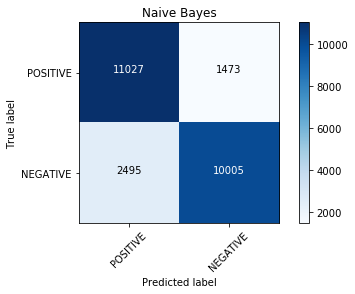

Naive Bayes Accuracy: 0.841280
Naive Bayes Precision: 0.815486
Naive Bayes Recall: 0.882160
Naive Bayes Sensitivity: 0.882160
Naive Bayes Specificity: 0.800400

Evaluate Logistic Regression Model
-------------------


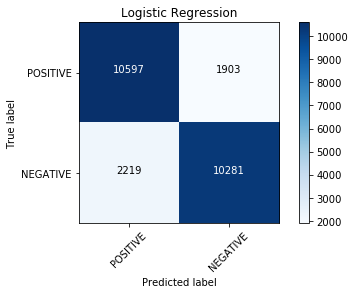

Logistic Regression Accuracy: 0.835120
Logistic Regression Precision: 0.826857
Logistic Regression Recall: 0.847760
Logistic Regression Sensitivity: 0.847760
Logistic Regression Specificity: 0.822480


In [162]:
main(method ="nlp", input_type = "imdb", min_word_count = 30, polarity_cutoff = 0.4)

### Interpreting the Results

1. **Accuracy**: Overall Accuracy of the model. This is equal to (Number of Reviews correctly classified) / Total Reviews.
2. **Precision**: The fraction of predicted Positive reviews that are actually Positive. Ideal case would be 100%
3. **Recall or Sensitivity which is True positive rate**: Fraction of Positive reviews that are correctly identified.  
    a. We would want Recall to be high, because if a Positive review is misclassified as Negative, it would not reflect the            true quality of the movie. People would miss out on a good movie if it is misclassified as Negative. We can                      compromise a little on accuracy and be prepared to put up with a relatively high false positive rate in order to get a          high true positive rate,  it is most important to identify possible movies which are give NEGATIVE rating when they are          actually POSITIVE. 
4. **Specificity which True negative rate**: Fraction of negative class identified correctly.
     
         

### Train and Evaluate Models on Twitter Data Sets

Reading twitter Data Set


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08

Total time elapsed: 00:00:08

Total time elapsed: 00:00:08

Total time elapsed: 00:00:08
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:08

Total time elapsed: 00:00:08

Total time elapsed: 00:00:08

Total time elapsed: 00:00:08

Total time elapsed: 00:00:08
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Removing Stop words
Gathering feature vectors. Using Minimum Word Count 75.000000 and Polarity Cut off 0.400000
Vocabulary Size (Unique Word List): 2461.000000
Training Naive Bayes
Training Logistic Regression
Training Complete
Evaluate Naive Bayes Model
-----------


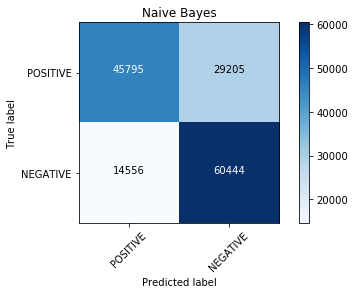

Naive Bayes Accuracy: 0.708260
Naive Bayes Precision: 0.758811
Naive Bayes Recall: 0.610600
Naive Bayes Sensitivity: 0.610600
Naive Bayes Specificity: 0.805920

Evaluate Logistic Regression Model
-------------------


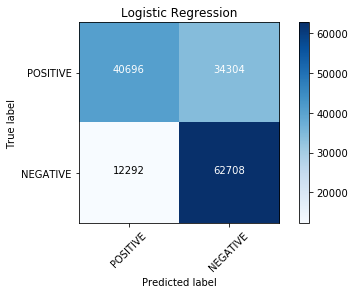

Logistic Regression Accuracy: 0.689360
Logistic Regression Precision: 0.768023
Logistic Regression Recall: 0.542613
Logistic Regression Sensitivity: 0.542613
Logistic Regression Specificity: 0.836107


In [163]:
main(method ="nlp", input_type = "twitter", min_word_count = 75, polarity_cutoff = 0.4)

### Interpreting Results
After trying with different minimum word counts and polarity cut off values, the above metrics is the best we could achieve. As you can see the model did not perform well with accuracy rates not exceeding 70%.  

Also, the recall is Worse at only ~61% for Naive Bayes and ~54% for logistic regression.

## Method 2: Generate Feature Vectors using Doc2Vec
Doc2vec was introduced by Le & Mikolov in their [ICML’14 paper](http://proceedings.mlr.press/v32/le14.pdf) - “Distributed Representations of Sentences and Documents. Doc2vec modifies the word2vec algorithm to unsupervised learning of continuous representations for larger blocks of text, such as sentences, paragraphs or entire documents.  

In order to understand Doc2Vec, it is advisable to understand the popular Word2Vec approach, as former is a straight forward extension of the latter. Word2vec based methods aim to compute vector representations of words (also known as word embeddings).
More details on Word2Vec and Doc2Vec can be found on this [Quora Post](https://www.quora.com/How-does-doc2vec-represent-feature-vector-of-a-document-Can-anyone-explain-mathematically-how-the-process-is-done).

Doc2Vec can be built using **"Distributed memory (dm)”** and **“Distributed bag of words (dbow)”** algorithms. It is proven that  the distributed memory model performed noticeably better and this model is set as default when running Doc2Vec. However, we can force the function to run DBOW model using the paramater dm =0.  

<img src="Doc2Vec.jpg">  

The idea is to concatenate the paragraph vectors (in this case reviews or tweets) with several word vectors from a paragraph and predict the following word in the given context. The paragraph vectors are also asked to contribute to the prediction task of the next word given many contexts sampled from the paragraph. 

In Paragraph Vector framework (see Figure above), every paragraph is mapped to a unique vector, represented by a column in matrix D and every word is also mapped to a unique vector, represented by a column in matrix W. The paragraph vector and word vectors are averaged or concatenated to predict the next word in a context. [The original paper by Quoc Le and Tomas Mikolov](http://proceedings.mlr.press/v32/le14.pdf) is an excellent read on Doc2Vec.

### Follow steps below to Contruct Feature Vectors

**Function Name: feature_vecs_DOC**  


The input to Doc2Vec is an iterator of LabeledSentence objects. Each such object represents a single sentence, and consists of two simple lists: a list of words and a list of labels.

### Why Labelize  sentence objects?
There is a need to specify that how many number of words or sentences convey a semantic meaning, so that the algorithm could identify it as a single entity. For this reason, we specify labels or tags to a sentence or paragraph depending on the level of semantic meaning conveyed.
In simple terms, a label denotes semantic meaning of something.  [Original Link](https://datascience.stackexchange.com/questions/10216/doc2vec-how-to-label-the-paragraphs-gensim)

Since, Doc2Vec in purely an unsupervised learning model, label will just be an unique arbitrary number per text example (In this case Reviews or Tweets). It's fine (and indeed memory-optimal in the gensim implementation) to just use contiguous integers starting with 0 as the label IDs.

### Instantiate Doc2Vec Object
Lets' create an instance of Doc2Vec model using the following parameters:

1. **min_count**: Ignore all words with total frequency lower than this. You have to set this to 1, since the sentence labels only appear once. Setting it any higher than 1 will miss out on the sentences.
2. **window**: The maximum distance between the current and predicted word within a sentence. 
3. **size**: Dimensionality of the feature vectors in output. 100 is a good number. If you’re extreme, you can go up to around 400.
4. **sample**: Threshold for configuring which higher-frequency words are randomly downsampled.
5. **workers**: Use this many worker threads to train the model

*Reference: (http://linanqiu.github.io/2015/10/07/word2vec-sentiment/)*

### Build the Vocabulary Table
Doc2Vec requires us to build the vocabulary table (simply digesting all the words and filtering out the unique words and count them). Vocabulary table is built using **model.build_vocab** which takes an array of Labelized sentences as input.


### Training the Model
Randomise the sequence of sentences before feeding into the model. This way the model is better trained.


### Generate feature Vectors
Finally, Use the docvecs function to extract the feature vectors for the training and test data



In [164]:
def feature_vecs_DOC(train_pos, train_neg, test_pos, test_neg):
    """
    Returns the feature vectors for all text in the train and test datasets.
    """
    # Doc2Vec requires LabeledSentence objects as input.
    # Turn the datasets from lists of words to lists of LabeledSentence objects.
    
    #print("Removing Stop words")
    #train_pos_clean,train_neg_clean, test_pos_clean, test_neg_clean  = remove_stopwords(train_pos, train_neg, test_pos, test_neg)
    
    def labelizeReviews(reviews, label_type):
        labelized = []
        for i,v in enumerate(reviews):
            label = '%s_%s'%(label_type,i)            
            labelized.append(LabeledSentence(v, [label]))
        return labelized
    
 
    # Labelize Reviews/ Tweets
    labeled_train_pos = labelizeReviews(train_pos, 'TRAIN_POS')
    labeled_train_neg = labelizeReviews(train_neg, 'TRAIN_NEG')
    labeled_test_pos =  labelizeReviews(test_pos, 'TEST_POS')
    labeled_test_neg =  labelizeReviews(test_neg, 'TEST_NEG')

    # Initialize model
    NUM_WORKERS = multiprocessing.cpu_count()
    model = Doc2Vec(min_count=1, alpha =  0.025, min_alpha=0.025, window=10, size=100, sample=1e-4, negative=5, workers=NUM_WORKERS)
    sentences = labeled_train_pos + labeled_train_neg + labeled_test_pos + labeled_test_neg
    model.build_vocab(sentences)
    
    train_pos_vec = []
    train_neg_vec = []
    test_pos_vec = []
    test_neg_vec = []
    
    
    # Train the model
    # This may take a bit to run 
    print("Training Doc2Vec using Distributed Memory and Negative Sampling")
    for i in range(5):
        print ("Training iteration %d" % (i))
        random.shuffle(sentences)
        model.train(sentences, total_examples=model.corpus_count, epochs=model.iter)
        model.alpha -= 0.002  # decrease the learning rate
        model.min_alpha = model.alpha  # fix the learning rate, no decay
        
    
    print("Generating Feature Vectors for Train POSITIVE")
    # Use the docvecs function to extract the feature vectors for the training and test data
    for i in range(len(labeled_train_pos)):
        inf_vector = model.docvecs[labeled_train_pos[i].tags[0]]
        train_pos_vec.append(inf_vector)
    train_pos_vec= np.array(train_pos_vec)
    
            
    print("Generating Feature Vectors for Train NEGATIVE")
    for i in range(len(labeled_train_neg)):
        inf_vector = model.docvecs[labeled_train_neg[i].tags[0]]        
        train_neg_vec.append(inf_vector)
    train_neg_vec = np.array(train_neg_vec)
    
            
    print("Generating Feature Vectors for Test POSITIVE")
    for i in range(len(labeled_test_pos)):
        inf_vector = model.docvecs[labeled_test_pos[i].tags[0]]        
        test_pos_vec.append(inf_vector)
    test_pos_vec = np.array(test_pos_vec)
    
            
    print("Generating Feature Vectors for Test NEGATIVE")
    for i in range(len(labeled_test_neg)):
        inf_vector = model.docvecs[labeled_test_neg[i].tags[0]]        
        test_neg_vec.append(inf_vector)
    test_neg_vec = np.array(test_neg_vec)
    
        
    print("Done")    
    # Return the four feature vectors
    return model, train_pos_vec, train_neg_vec, test_pos_vec, test_neg_vec

### Quick Data Validation
Let's do a quick data validation on the training feature vectors and understand what we can infer from them.

In [165]:
train_pos, train_neg, test_pos, test_neg = load_data('imdb','d2v')
model, train_pos_vec, train_neg_vec, test_pos_vec, test_neg_vec = feature_vecs_DOC(train_pos, train_neg, test_pos, test_neg)

Reading imdb Data Set


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


Training Doc2Vec using Distributed Memory and Negative Sampling
Training iteration 0
Training iteration 1
Training iteration 2
Training iteration 3
Training iteration 4
Generating Feature Vectors for Train POSITIVE
Generating Feature Vectors for Train NEGATIVE
Generating Feature Vectors for Test POSITIVE
Generating Feature Vectors for Test NEGATIVE
Done


Print Most similar Reviews to the very Any Positive review in IMDB data set

In [166]:
review_no = 23  # Change the review number as desired
infv = model.infer_vector(train_pos[review_no])
similar_docs = model.docvecs.most_similar([infv], topn=len(model.docvecs))
select_doc = random.randint(0,len(similar_docs))

indices = [x.start() for x in re.finditer("_", similar_docs[select_doc][0])]

get_index = int(similar_docs[select_doc][0][indices[1]+1:])

print("Positive Review No: %d" % review_no)
print("------------------------------")
print(' '.join(train_pos[review_no]))
print("------------------------------")
print("Similar Review 1")
print("------------------------------")
print(' '.join(train_pos[get_index]))

select_doc = random.randint(0,len(similar_docs))
get_index = int(similar_docs[select_doc][0][indices[1]+1:])
print("------------------------------")
print("Similar Review 2")
print("------------------------------")
print(' '.join(train_pos[get_index]))



Positive Review No: 23
------------------------------
the legendary boris karloff ended his illustrious career making four cheapie fright flick clunkers mexico this the token moody period gothic horror entry from the bunch karloff gives typically spry and dignified performance matthias morteval elderly eccentric patriarch who invites several his petty greedy and backbiting count relatives his creepy rundown castle for the reading will pretty soon the hateful guests are getting bumped off lethal life sized toy people who populate the place onetime mexican sex symbol andres garcia tintorera infamy portrays the dashing police officer hero and julissa looks absolutely ravishing the sole likable female character the clunky plodding non direction trite the numbers script ugly washed out cinematography ridiculous murder set pieces gross fat slob gets blasted right the face miniature cannon overwrought string score morbid gloom doom atmosphere largely lousy acting karloff notably excepted chee

Similarly print most simlar words related to any word

In [167]:
model.most_similar('excellent')


[('superb', 0.7798666954040527),
 ('terrific', 0.7310423851013184),
 ('outstanding', 0.7275811433792114),
 ('fine', 0.692394495010376),
 ('great', 0.687579333782196),
 ('fantastic', 0.6839812994003296),
 ('wonderful', 0.6603418588638306),
 ('solid', 0.6517915725708008),
 ('exceptional', 0.6311179399490356),
 ('marvellous', 0.5782872438430786)]

In [168]:
model.most_similar('poor')

[('weak', 0.6218351125717163),
 ('terrible', 0.5875034332275391),
 ('lousy', 0.5631139278411865),
 ('dreadful', 0.5564313530921936),
 ('horrible', 0.5393791198730469),
 ('pitiful', 0.5376462936401367),
 ('horrid', 0.5320767164230347),
 ('lame', 0.5147217512130737),
 ('awful', 0.5124568343162537),
 ('bad', 0.5012640357017517)]

In [169]:
del train_pos, train_neg, test_pos, test_neg
del model, train_pos_vec, train_neg_vec, test_pos_vec, test_neg_vec
del infv, similar_docs, select_doc, indices, get_index

### Classifying Sentiments  (Fit the Model)

**Function Name: build_models_DOC and build_models_Neuralnet**  

Feature vectors generate above can be used to classify sentiments of IMDB and Twitter Data sets. We train Gaussian Naive Bayes and Stochastic Gradient Descent Logistic Regression models to predict sentiments on the Test set.  

**Gaussian Naive Bayes**
GaussianNB implements the Gaussian Naive Bayes algorithm for classification. The likelihood of the features is assumed to be Gaussian:
<img src="Gaussian_NB.jpg"> 



In this project, we will also use a 3 layer feed forward Neural network to train using the feature vectors and predict sentiments. Performance is compared between 3 models


### Gaussian NB and Logistic Regression

In [170]:
def build_models_DOC(train_pos_vec, train_neg_vec, test_pos_vec, test_neg_vec):
    """
    Returns a GaussianNB and LosticRegression Model that are fit to the training data.
    """
    X = np.concatenate((train_pos_vec,train_neg_vec),axis =0)
    Y = np.array(["POSITIVE"]*len(train_pos_vec) + ["NEGATIVE"]*len(train_neg_vec))
    
    assert(len(X) == len(Y))

    # Use sklearn's GaussianNB and LogisticRegression functions to fit two models to the training data.
    # For LogisticRegression, pass no parameters
    print("Training Gaussian Naive Bayes")
    nb_model = NB.GaussianNB()
    nb_model.fit(X, Y)
    
    print("Training Logistic Regression")
    lr_model = LR.SGDClassifier()
    lr_model.fit(X , Y)
    
    print("Training Neural Network using Tensorflow")
    test_predictions = build_models_Neuralnet(train_pos_vec, train_neg_vec, test_pos_vec, test_neg_vec)
    
    print("Training Complete")
    
    return nb_model, lr_model, test_predictions

### Neural network using Tensorflow

In [171]:
def build_models_Neuralnet(train_pos_vec, train_neg_vec, test_pos_vec, test_neg_vec):
    
    def batches(batch_size, features, labels):
        n_batches = len(features)//batch_size
    
    # only full batches    
        features = features[:n_batches*batch_size]
        for i in range(0, len(features), batch_size):
            batch_X = features[i:i + batch_size]
            batch_Y = labels[i:i + batch_size]
            yield batch_X, batch_Y
        
    def print_epoch_stats(epoch_i, sess, last_features, last_labels):
        """
        Print cost and validation accuracy of an epoch
        """
        current_cost = sess.run(cost,feed_dict={features: last_features, labels: last_labels})
        training_accuracy = sess.run(accuracy,feed_dict={features: last_features, labels: last_labels})
        valid_accuracy = sess.run(accuracy,feed_dict={features: valid_features, labels: valid_labels})
        print('Epoch: {:<4} - Cost: {:<8.3} Training Accuracy: {:<5.3} Validation Accuracy: {:<5.3}'.format(epoch_i,current_cost, training_accuracy, valid_accuracy))
        
    def one_hot_encode(x):
        """
        One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
        : x: List of sample Labels
        : return: Numpy array of one-hot encoded labels
        """
        one_hot_array=[]
        for l in x:
            holder = np.repeat(0,2)
            np.put(holder,l,1)
            one_hot_array.append(holder)
    
        return np.array(one_hot_array)
    
    def fully_connected(features_tensor, num_outputs, num_inputs = None):
        """
        Apply a fully connected layer to x_tensor using weight and bias
        : x_tensor: A 2-D tensor where the first dimension is batch size.
        : num_outputs: The number of output that the new tensor should be.
        : return: A 2-D tensor where the second dimension is num_outputs.
        """
        if (num_inputs != None):
            inputs = num_inputs
        else:
            inputs = features_tensor.get_shape().as_list()[1]
        weights = tf.Variable(tf.truncated_normal([inputs, num_outputs],stddev=0.1))
        bias = tf.Variable(tf.truncated_normal([num_outputs],stddev=0.1))        
        fc = tf.add(tf.matmul(features_tensor,weights),bias)
        fc = tf.nn.sigmoid(fc)
        #fc = tf.nn.relu(fc)
        #fc = tf.nn.dropout(fc, keep_prob = 0.70)
        return fc
        
    
    n_input = 100
    n_classes = 2
    ip_features = np.concatenate((train_pos_vec,train_neg_vec),axis =0)
    ip_labels = np.array([1]*len(train_pos_vec) + [0]*len(train_neg_vec))
    
    ip_labels = one_hot_encode(ip_labels)
    
    
    train_features, valid_features, train_labels, valid_labels = train_test_split(ip_features, ip_labels, test_size=0.2)

    
    test_features = np.concatenate((test_pos_vec,test_neg_vec),axis =0)
    test_labels = np.array([1]*len(test_pos_vec) + [0]*len(test_neg_vec))
    test_labels = one_hot_encode(test_labels)
    
    # Features and Labels
    features = tf.placeholder(tf.float32, [None, n_input])
    labels = tf.placeholder(tf.float32, [None, n_classes])
    
    layer_1 = fully_connected(features, num_outputs = 256, num_inputs = n_input)
    layer_2 = fully_connected(layer_1, num_outputs = 512)
    logits = fully_connected(layer_2, num_outputs = n_classes)

     
    # Define loss and optimizer
    learning_rate = tf.placeholder(tf.float32)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

    # Calculate accuracy
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    init = tf.global_variables_initializer()

    batch_size = 128
    epochs = 250
    learn_rate = 0.001
        
    with tf.Session() as sess:
        sess.run(init)

        # Training cycle
        print("Training 4 layer Feed forward Neural Network classifier over Do2Vec Vectors")
        for epoch_i in range(epochs+1):
            train_batches = batches(batch_size, train_features, train_labels)
            # Loop over all batches
            for batch_features, batch_labels in train_batches:
                train_feed_dict = {
                        features: batch_features,
                        labels: batch_labels,
                        learning_rate: learn_rate}
                sess.run(optimizer, feed_dict=train_feed_dict)                

            # Print cost and validation accuracy for every 10 iterations
            if (epoch_i%25 == 0):
                print_epoch_stats(epoch_i, sess, batch_features, batch_labels)

        # Calculate accuracy for test dataset
        test_accuracy = sess.run(
                accuracy,
                feed_dict={features: test_features, labels: test_labels})
        
        pred =  logits
        test_feed_dict = { features: test_features}
        prediction = sess.run(pred,feed_dict = test_feed_dict)
        

        print('Test Accuracy: {}'.format(test_accuracy))
    
    
    test_predictions = []
    for i in range(len(prediction)):
        if prediction[i][1] >= 0.5:
            test_predictions.append('POSITIVE')
        else:
            test_predictions.append('NEGATIVE')
    test_predictions =np.array(test_predictions)
    
    return test_predictions
    

### Train and Evaluate the Model on IMDB Data Sets
Let's use the main function we created above (which internally calls feature_vecs_DOC,build_models_DOC and build_models_Neuralnet) functions to train and evaluate Naive Bayes, Logistic Regression and Neural Net Models


Reading imdb Data Set


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Training Doc2Vec using Distributed Memory and Negative Sampling
Training iteration 0
Training iteration 1
Training iteration 2
Training iteration 3
Training iteration 4
Generating Feature Vectors for Train POSITIVE
Generating Feature Vectors for Train NEGATIVE
Generating Feature Vectors for Test POSITIVE
Generating Feature Vectors for Test NEGATIVE
Done
Training Gaussian Naive Bayes
Training Logistic Regression
Training Neural Network using Tensorflow
Training 4 layer Feed forward Neural Network classifier over Do2Vec Vectors
Epoch: 0    - Cost: 0.44     Training Accuracy: 0.875 Validation Accuracy: 0.856
Epoch: 25   - Cost: 0.395    Training Accuracy: 0.914 Validation Accuracy: 0.861
Epoch: 50   - Cost: 0.386    Training Accuracy: 0.93  Validation Accuracy: 0.861
Epoch: 75   - Cost: 0.384    Training Accuracy: 0.93  Validation Accuracy: 0.859
Epoch: 100  - Cost: 0.384    Training Accuracy: 0.93  Validation Accuracy: 0.855
Epoch: 125  - Cost: 0.376    Training Accuracy: 0.938 Validatio

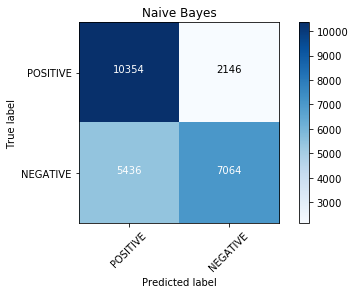

Naive Bayes Accuracy: 0.696720
Naive Bayes Precision: 0.655731
Naive Bayes Recall: 0.828320
Naive Bayes Sensitivity: 0.828320
Naive Bayes Specificity: 0.565120

Evaluate Logistic Regression Model
-------------------


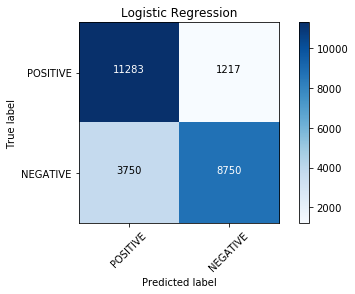

Logistic Regression Accuracy: 0.801320
Logistic Regression Precision: 0.750549
Logistic Regression Recall: 0.902640
Logistic Regression Sensitivity: 0.902640
Logistic Regression Specificity: 0.700000

4 Layer Feed forward Neural Network model for Doc2Vec
-------------------


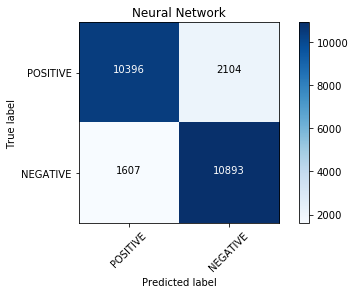

Neural Network Accuracy: 0.851560
Neural Network Precision: 0.866117
Neural Network Recall: 0.831680
Neural Network Sensitivity: 0.831680
Neural Network Specificity: 0.871440


In [172]:
main(method ="d2v", input_type = "imdb")

### Interpreting the Results
Neural network with 3 layers gave the best accuracy.   

For Recall, Logistic regression performed better with 88% compared to 85% for the neural network.
If Fraction of Positive reviews that are correctly identified does not matter, go ahead with Neural network model.

### Train and Evaluate the Model on Twitter Data Sets

Reading twitter Data Set


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05

Total time elapsed: 00:00:05

Total time elapsed: 00:00:05

Total time elapsed: 00:00:05
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:05

Total time elapsed: 00:00:05

Total time elapsed: 00:00:05

Total time elapsed: 00:00:05

Total time elapsed: 00:00:05
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:01


Training Doc2Vec using Distributed Memory and Negative Sampling
Training iteration 0
Training iteration 1
Training iteration 2
Training iteration 3
Training iteration 4
Generating Feature Vectors for Train POSITIVE
Generating Feature Vectors for Train NEGATIVE
Generating Feature Vectors for Test POSITIVE
Generating Feature Vectors for Test NEGATIVE
Done
Training Gaussian Naive Bayes
Training Logistic Regression
Training Neural Network using Tensorflow
Training 4 layer Feed forward Neural Network classifier over Do2Vec Vectors
Epoch: 0    - Cost: 0.537    Training Accuracy: 0.773 Validation Accuracy: 0.686
Epoch: 25   - Cost: 0.545    Training Accuracy: 0.75  Validation Accuracy: 0.695
Epoch: 50   - Cost: 0.533    Training Accuracy: 0.742 Validation Accuracy: 0.699
Epoch: 75   - Cost: 0.52     Training Accuracy: 0.773 Validation Accuracy: 0.696
Epoch: 100  - Cost: 0.5      Training Accuracy: 0.797 Validation Accuracy: 0.693
Epoch: 125  - Cost: 0.495    Training Accuracy: 0.805 Validatio

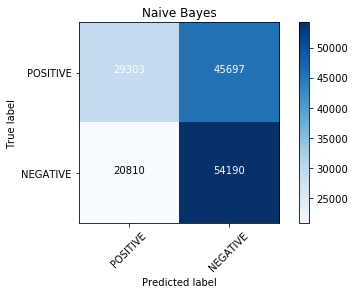

Naive Bayes Accuracy: 0.556620
Naive Bayes Precision: 0.584738
Naive Bayes Recall: 0.390707
Naive Bayes Sensitivity: 0.390707
Naive Bayes Specificity: 0.722533

Evaluate Logistic Regression Model
-------------------


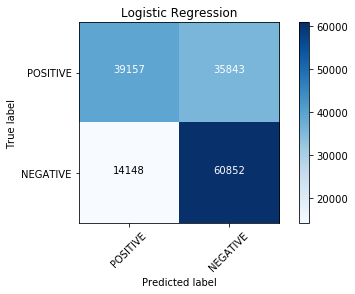

Logistic Regression Accuracy: 0.666727
Logistic Regression Precision: 0.734584
Logistic Regression Recall: 0.522093
Logistic Regression Sensitivity: 0.522093
Logistic Regression Specificity: 0.811360

4 Layer Feed forward Neural Network model for Doc2Vec
-------------------


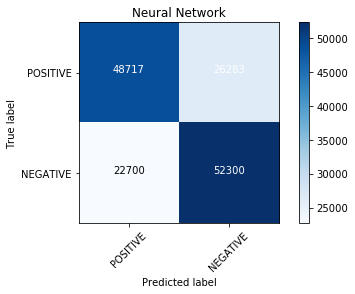

Neural Network Accuracy: 0.673447
Neural Network Precision: 0.682149
Neural Network Recall: 0.649560
Neural Network Sensitivity: 0.649560
Neural Network Specificity: 0.697333


In [173]:
main(method ="d2v", input_type = "twitter")


## Conclusion
**IMDB Data Set**  
While predicting the Sentiment for the IMDB data set, Doc2Vec did not outperform the traditional Bag-of-Words Model.  
In Fact, Using Naive Bayes classification, Bag-of-Words resulted in an accuracy of 84%, wheres Doc2Vec gave only 65%.  

Using Logistic Regression with Stochastic Gradient Descent, accuracy hovered over 84% for both the techniques.  

We also tried to fit a 3 layer feed forward Neural network using the feature vectors generated by Doc2Vec, and surprisingly the accuracy was almost equal to that of logistic regression. The model did not converge yet. Fine tuning the number of epochs and the learning rate will even take the accuracy above 90%.

**Twitter Data Set**  

Doc2Vec was clearly a winner while predicting the sentiment for Twitter feeds.  
Using traditional Bag-of-Words model, Naive Bayes classification gave an accuracy of only 70%. Logistic Regression with Stochastic Gradient Descent merely touched 69%.

Twitter feeds may contain a lot of words which are misspelled and grammatically incorrect. Capturing sentiment using a traditional bag-of-words model would be a daunting task due to a variety of unique words that get generated. They lose the ordering of the words and also ignore semantics.   

**Doc2Vec - The Advantage**  

Doc2Vec represents each document by a dense vector which is trained to predict words in the document even though they are mispelled and gramatically incorrect. This model built on an algorithm called Distributed Memory (DM) which uses a sliding context window to predict a (typically) center word, thus, word *proximity* matters. Also, random windows *up to* the configured size are used, so closer words are more often trained, meaning relative proximity also matters. 

Its construction gives the algorithm the potential to overcome the weaknesses of bag-of words models. Empirical results show that Paragraph Vectors outperform bag-of-words models as well as other techniques for text representations. This technique has already achieved new state-of-the-art results on several text classification and sentiment
analysis tasks.



## References
1. [Doc2Vec Tutorial by Radim Rehurek](https://rare-technologies.com/doc2vec-tutorial/)
2. Quora - [How does doc2vec represent feature vector of a document](https://www.quora.com/How-does-doc2vec-represent-feature-vector-of-a-document-Can-anyone-explain-mathematically-how-the-process-is-done)
3. [Modern Methods for Sentiment Analysis by Michael Czerny](https://districtdatalabs.silvrback.com/modern-methods-for-sentiment-analysis)
4. [Deep learning with paragraph2vec](http://radimrehurek.com/gensim/models/doc2vec.html#gensim.models.doc2vec.LabeledSentence)
5. [Sentiment Analysis Using Doc2Vec](http://linanqiu.github.io/2015/10/07/word2vec-sentiment/)
6. [Distributed Representations of Sentences and Documents by Quoc Le and Tomas Mikolov](https://cs.stanford.edu/~quocle/paragraph_vector.pdf)

